In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *

In [3]:
PATH = "datasets/yeast_v4"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [5]:
stats_name = "yeast_v4_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmr1KO': 3}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/home/user/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


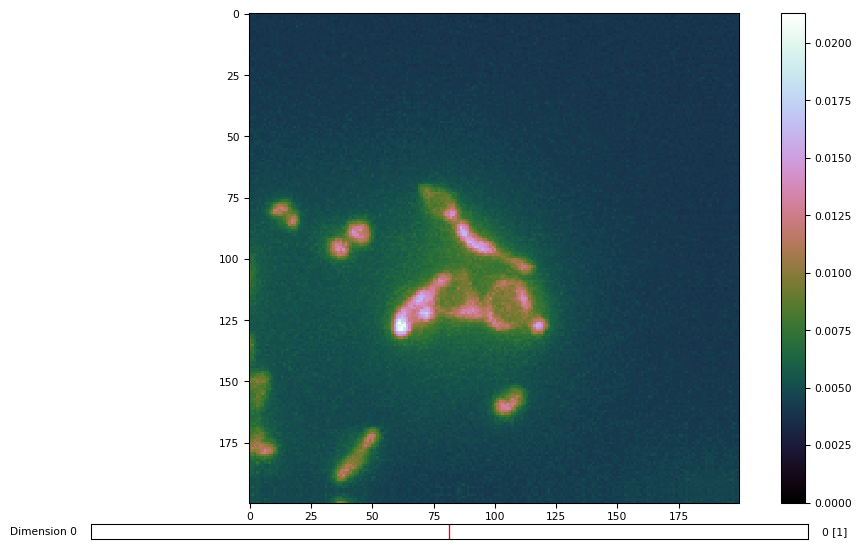

In [10]:
idx = 0
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [11]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [12]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [13]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=80000, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=4, bias=True)
   )
 ), [3200000, 40, 160, 4])

In [14]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 80000]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 3200040)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 164)]))])

In [15]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

[0]:  20.0                                               
[1]: 76.92
[2]:   4.0
[3]: 4.167
epoch      trn_loss   val_loss   accuracy   
    0      1.420836   1.377092   0.266667  
[0]: 23.33                                               
[1]: 69.23
[2]:   4.0
[3]: 4.167
    1      1.415425   1.3762     0.257143  
[0]: 23.33                                               
[1]: 69.23
[2]:   4.0
[3]: 4.167
    2      1.41207    1.375266   0.257143  
[0]: 26.67                                               
[1]: 69.23
[2]:   4.0
[3]: 4.167
    3      1.409331   1.374028   0.266667  
[0]: 33.33                                                
[1]: 69.23
[2]:   4.0
[3]: 4.167
    4      1.407087   1.373138   0.285714  
  0%|          | 0/10 [00:00<?, ?it/s]

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [ ]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [ ]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [ ]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [ ]:
learn.summary()

In [ ]:
wd=1e-5

In [ ]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.save('tmp_resnet_clr')